# Feature Engineering (The Scorecard Build)

BayesRisk Project

**Author:** Desmond Momanyi Mariita

**Date:** 2026-01-11

---

## 1. Objectives

This is the most "quant" part of the project. We are moving away from raw data (e.g., "Income = $65,000") to Risk Signals (e.g., "Income Bin 4 = Risk Score 0.5").
##### The Concept: Why Weight of Evidence (WoE)?
Logistic Regression assumes a linear relationship (as X goes up, Risk goes up). But real data isn't linear:

- Income: Going from $20k to $40k reduces risk significantly. Going from $200k to $220k barely matters.

- Missing Values: How do you plug "NaN" into a regression equation? You can't.

WoE solves both:
1. Binning: We group $200k and $220k into the same bucket.
2. Transformation: We replace the bucket name with a number: $WoE = \ln(\frac{\%Good}{\%Bad})$.
3. Result: "Missing" becomes just another number (e.g., 0.12), and non-linear curves become linear.

## 2. Implementation

#### Step 1: Setup & Load

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the base file
file_path = '../../data/interim/loans_batch4.pkl'
df = pd.read_pickle(file_path)

# Quick check
print(f"Data Loaded: {df.shape}")

Data Loaded: (1877679, 142)


#### Step 2: The WoE & IV Engine
This is the core engine of a Credit Risk team. This function calculates the Weight of Evidence (Value) and Information Value (Strength) for any variable.

In [3]:
def calculate_woe_iv(df: pd.DataFrame, feature: str, target: str = 'target') -> pd.DataFrame:
    """
    Calculates Weight of Evidence (WoE) and Information Value (IV) for a categorical feature.
    
    The IV tells us 'How useful is this variable?'
    - IV < 0.02: Useless
    - 0.02 - 0.1: Weak
    - 0.1 - 0.3: Medium
    - 0.3 - 0.5: Strong
    - > 0.5: Suspicious (Leakage?)

    Args:
        df (pd.DataFrame): Dataframe with the feature and target.
        feature (str): Name of the column to analyze.
        target (str): Name of the binary target column.

    Returns:
        pd.DataFrame: A summary table with Counts, Goods, Bads, WoE, and IV per bin.
    """
    # 1. Create a working dataframe
    lst = []
    
    # 2. Iterate through each unique category (bin) in the feature
    for val in df[feature].unique():
        # Handle NaN separately if they exist
        if pd.isna(val):
            val_df = df[df[feature].isna()]
            val_name = 'Missing'
        else:
            val_df = df[df[feature] == val]
            val_name = val
            
        # 3. Calculate Good/Bad counts
        all_count = len(val_df)
        bad_count = val_df[target].sum()
        good_count = all_count - bad_count
        
        lst.append({
            'Value': val_name,
            'All': all_count,
            'Good': good_count,
            'Bad': bad_count
        })
        
    # 4. Create DataFrame and calculate aggregates
    woe_df = pd.DataFrame(lst)
    
    # Calculate distributions
    total_good = woe_df['Good'].sum()
    total_bad = woe_df['Bad'].sum()
    
    woe_df['Dist_Good'] = woe_df['Good'] / total_good
    woe_df['Dist_Bad'] = woe_df['Bad'] / total_bad
    
    # 5. Calculate WoE
    # Add a small epsilon to avoid division by zero (if a bin has 0 bads)
    epsilon = 0.0001
    woe_df['WoE'] = np.log((woe_df['Dist_Good'] + epsilon) / (woe_df['Dist_Bad'] + epsilon))
    
    # 6. Calculate IV
    woe_df['IV'] = (woe_df['Dist_Good'] - woe_df['Dist_Bad']) * woe_df['WoE']
    
    # Sort by WoE to see the trend
    woe_df = woe_df.sort_values(by='WoE')
    
    return woe_df

#### Step 3: Binning Continuous Variables
We cannot run WoE on raw income (too many unique values). You must Bin it first.

Action: Bin annual_inc and dti using Deciles (10 equal buckets).

In [4]:
# --- Binning Annual Income ---
# qcut creates Quantile-based discretization (Equal population in each bin)

df['annual_inc_bin'] = pd.qcut(df['annual_inc'], q=10, duplicates='drop')

# --- Binning DTI ---
# Clip DTI first to handle outliers (as decided in Batch 2)

df['dti_clipped'] = df['dti'].clip(upper=100)
df['dti_bin'] = pd.qcut(df['dti_clipped'], q=10, duplicates='drop')

print("Binning Complete.")
display(df[['annual_inc', 'annual_inc_bin']].head())

Binning Complete.


,annual_inc,annual_inc_bin
0,24000.0,"(-0.001, 34000.0]"
1,30000.0,"(-0.001, 34000.0]"
2,12252.0,"(-0.001, 34000.0]"
3,49200.0,"(42000.0, 50000.0]"
4,80000.0,"(75000.0, 85000.0]"


#### Step 4: Run WoE Analysis
Now we apply the engine to our new bins to see if they predict risk monotonically.

Information Value (IV) for Income: 0.0228


,Value,All,Good,Bad,Dist_Good,Dist_Bad,WoE,IV
0,"(-0.001, 34000.0]",190691,144621,46070,0.096557,0.121270,-0.227678,0.005627
3,"(34000.0, 42000.0]",191063,147422,43641,0.098427,0.114876,-0.154396,0.002540
1,"(42000.0, 50000.0]",215862,168668,47194,0.112612,0.124229,-0.098095,0.001140
8,"(50000.0, 57500.0]",153506,121073,32433,0.080835,0.085373,-0.054561,0.000248
7,"(57500.0, 65000.0]",212168,167626,44542,0.111916,0.117248,-0.046500,0.000248
4,"(65000.0, 75000.0]",202613,162201,40412,0.108294,0.106376,0.017849,0.000034
2,"(75000.0, 85000.0]",161709,130327,31382,0.087013,0.082607,0.051907,0.000229
5,"(85000.0, 100000.0]",187589,153288,34301,0.102343,0.090291,0.125170,0.001509
6,"(100000.0, 129129.76]",174710,144889,29821,0.096736,0.078498,0.208671,0.003806
9,"(129129.76, 110000000.0]",187768,157668,30100,0.105268,0.079232,0.283811,0.007389


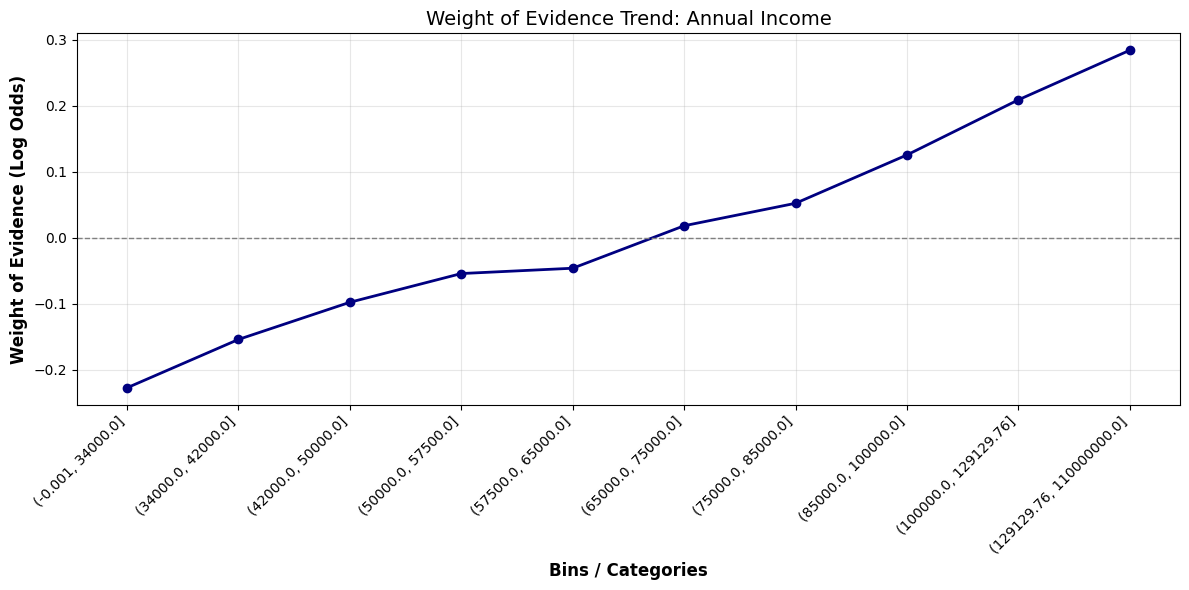

In [8]:
# Calculate WoE for Income
woe_inc = calculate_woe_iv(df, 'annual_inc_bin')

# Display the table
print(f"Information Value (IV) for Income: {woe_inc['IV'].sum():.4f}")
display(woe_inc)

# Visualization Function
def plot_woe(woe_df: pd.DataFrame, feature_name: str) -> None:
    """
    Visualizes the Weight of Evidence (WoE) trend across bins.
    
    This plot checks for 'Monotonicity'. A valid predictive feature should 
    generally show a trend that goes strictly up or down (or a logical U-shape).
    Zig-zagging lines indicate the need for coarser binning.

    Args:
        woe_df (pd.DataFrame): The output from calculate_woe_iv(). 
                               Must contain 'Value' (bin name) and 'WoE'.
        feature_name (str): The name of the feature for the plot title.

    Returns:
        None: Displays a matplotlib figure.
    """
    # Create figure and axis explicitly
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the WoE line using numeric x positions instead of categorical values
    x_pos = range(len(woe_df))
    ax.plot(x_pos, woe_df['WoE'], marker='o', color='navy', lw=2)
    
    # Add reference line at 0 (Average Risk)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    
    # Set Title and Labels
    ax.set_title(f'Weight of Evidence Trend: {feature_name}', fontsize=14)
    ax.set_xlabel('Bins / Categories', fontsize=12, fontweight='bold')
    ax.set_ylabel('Weight of Evidence (Log Odds)', fontsize=12, fontweight='bold')
    
    # Set x-axis ticks and labels using numeric positions
    ax.set_xticks(x_pos)
    ax.set_xticklabels(woe_df['Value'].astype(str), rotation=45, ha='right')
    
    # Grid and Layout
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_woe(woe_inc, 'Annual Income')

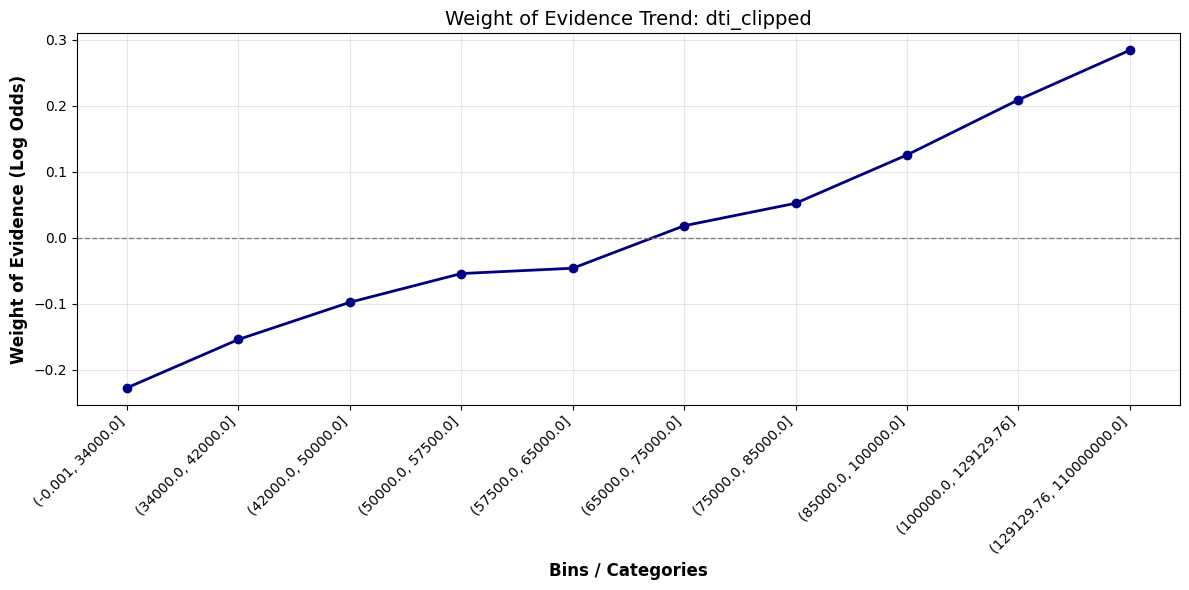

In [9]:
plot_woe(woe_inc, 'dti_clipped')

## 3. Results & Analysis

#### 3.1 The Monotonicity Test

Now that we have the plot for Annual Income and debt to income, we need to interpret it.

The Rule: A variable is only safe for Logistic Regression if its WoE trend is Monotonic (strictly going up or strictly going down).
- Income: Usually Monotonic. As Income goes up, WoE goes up (Risk goes down).
- DTI (Debt-to-Income): Often Non-Monotonic.
    - Low DTI (0-5%): Surprisingly risky (people with 0 debt often have no credit history).
    - Medium DTI (10-20%): Safe.
    - High DTI (30%+): Risky.
    - Result: The plot looks like a "Checkmark" or "U-shape".

If we feed a "U-shape" into a standard Linear model, the model will draw a straight line through the middle and fail. We must fix this using Coarse Classing (Manual Binning).

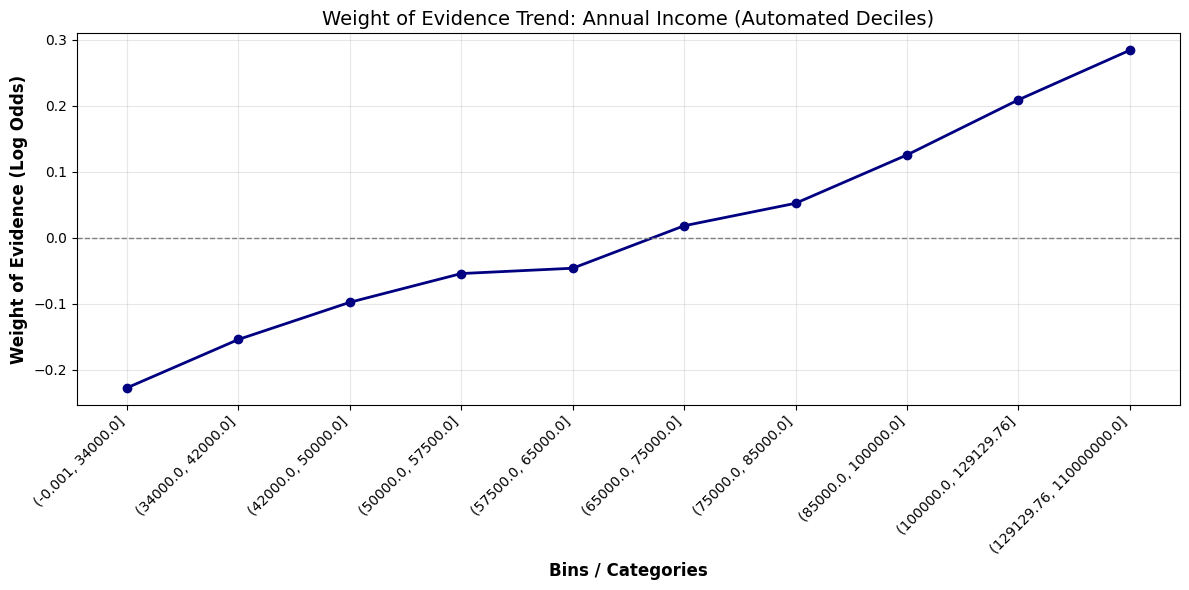

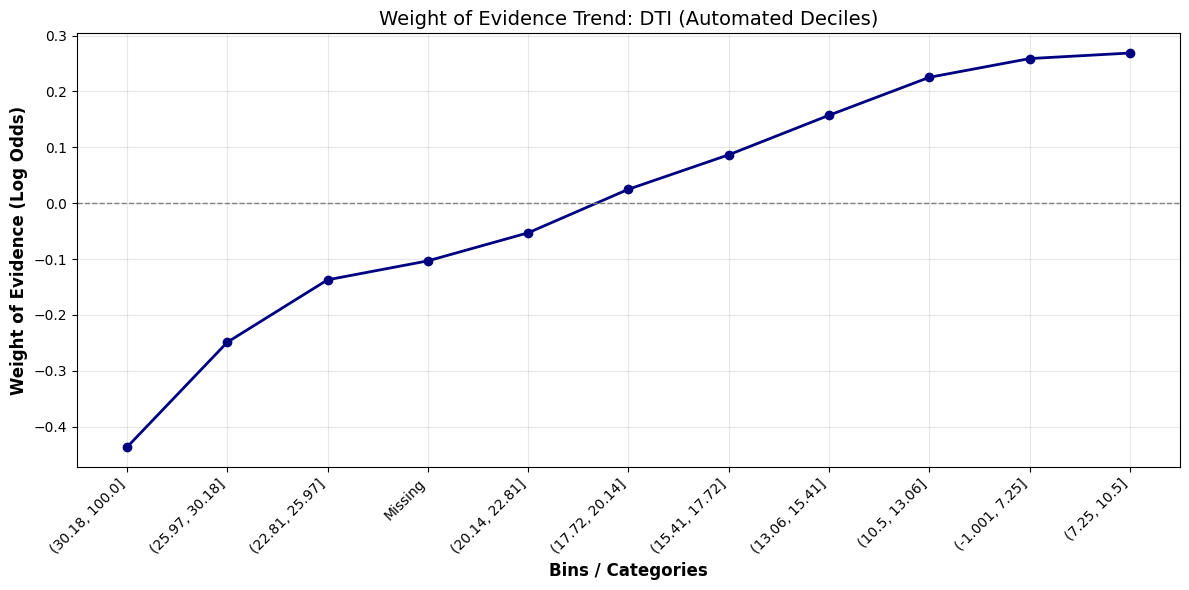

In [ ]:
# 1. Income (Should be monotonic: Higher Income = Higher WoE)

plot_woe(woe_inc, 'Annual Income (Automated Deciles)')

# 2. Calculate and Plot DTI (Debt-to-Income)

woe_dti = calculate_woe_iv(df, 'dti_bin')
plot_woe(woe_dti, 'DTI (Automated Deciles)')

#### 3.2 What to expect (The "Zig-Zag" Problem)
- Income: We should see a relatively straight line going up. This is good.

- DTI: We will likely see a "Checkmark" shape or a zig-zag.

    - Why? Borrowers with DTI < 10% often have higher default rates than those with 10-15% (thin credit history vs. established history).

    - The Fix: We cannot feed a zig-zag into Logistic Regression. We must manually merge these bins.

#### 3.3 The Fix: Coarse Classing (Manual Binning)
If our dti plot looks messy, we use this code to apply Manual Breaks that force a smooth trend.

IV for Manual DTI: 0.0479


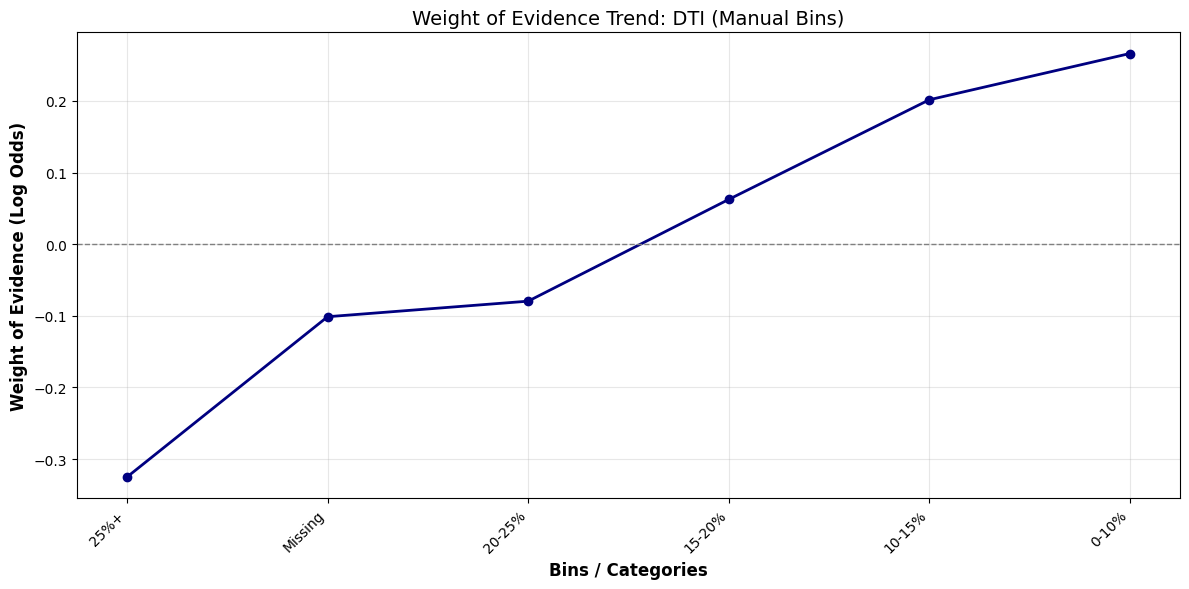

In [15]:
def apply_manual_bins(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Applies 'Coarse Classing' (Manual Binning) to smooth out zig-zagging WoE trends.
    
    When automated binning (e.g., deciles) produces non-monotonic WoE trends, we use
    manual binning to merge adjacent bins and force a smooth, monotonic relationship.
    This ensures the feature can be safely used in Logistic Regression.
    
    For DTI: We merge low DTI values (which paradoxically show high risk due to thin 
    credit history) with medium DTI to create 5 smooth categories that show monotonic risk.

    Args:
        df_in (pd.DataFrame): Dataframe with 'dti_clipped' column already created.

    Returns:
        pd.DataFrame: Same dataframe with new 'dti_manual_bin' column added containing
                     the manually binned DTI categories as strings (e.g., '0-10%', '10-15%').
    """
    df_out = df_in.copy()
    
    # --- DTI Manual Cuts ---
    # We merge the "low DTI" riskiness with the "medium" bucket to smooth the curve.
    # Logic: <10% | 10-15% | 15-20% | 20-25% | 25%+
    dti_bins = [-1, 10, 15, 20, 25, 1000]
    dti_labels = ['0-10%', '10-15%', '15-20%', '20-25%', '25%+']
    
    # Use pd.cut (for specific edges) instead of qcut (for equal counts)
    df_out['dti_manual_bin'] = pd.cut(
        df_out['dti_clipped'], 
        bins=dti_bins, 
        labels=dti_labels
    )
    
    return df_out

# Apply and Re-Test
df = apply_manual_bins(df)
woe_dti_manual = calculate_woe_iv(df, 'dti_manual_bin')

print(f"IV for Manual DTI: {woe_dti_manual['IV'].sum():.4f}")
plot_woe(woe_dti_manual, 'DTI (Manual Bins)')

The output confirms that our manual binning logic is working. Now we must perform Binning for the remaining continuous variables before we can calculate the Information Value (IV) for the whole dataset.

Weight of Evidence (WoE) requires all inputs to be categorical (binned). We have handled Income and DTI, but we still need to bin the "Character" variables (credit_hist_years, revol_util, etc.).

##### Step 1: Binning the Remaining Features
We cannot use standard "Deciles" for everything.

- Delinquency (mths_since_last_delinq): Needs "Time Windows" (e.g., <1 year, <2 years), not equal-sized chunks.

- Credit History & Utilization: Standard Deciles (qcut) work well here.

In [16]:
def bin_remaining_features(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Completes the binning phase by handling the remaining continuous variables.
    
    Strategies:
    1. mths_since_last_delinq_clean: Uses explicit time windows (0-12m, 12-24m, etc.) 
       to align with standard risk policy definitions.
    2. credit_hist_years: Uses automatic Deciles (10 equal-sized bins).
    3. revol_util_clean: Uses automatic Deciles.

    Args:
        df_in (pd.DataFrame): The dataframe with cleaned continuous features.

    Returns:
        pd.DataFrame: Dataframe with new categorical '_bin' columns.
    """
    df_out = df_in.copy()
    
    # --- 1. Delinquency (Custom Time Windows) ---
    # 0-12 months is the "Danger Zone". 999 is "Clean".
    delinq_bins = [-1, 6, 12, 24, 60, 120, 1000]
    delinq_labels = ['0-6m', '6-12m', '12-24m', '2-5yr', '5-10yr', 'Never/Old']
    
    df_out['delinq_bin'] = pd.cut(
        df_out['mths_since_last_delinq_clean'], 
        bins=delinq_bins, 
        labels=delinq_labels
    )
    
    # --- 2. Credit History (Deciles) ---
    # Using qcut for equal-sized populations
    df_out['credit_hist_bin'] = pd.qcut(
        df_out['credit_hist_years'], 
        q=10, 
        duplicates='drop'
    )
    
    # --- 3. Revolving Utilization (Deciles) ---
    df_out['revol_util_bin'] = pd.qcut(
        df_out['revol_util_clean'], 
        q=10, 
        duplicates='drop'
    )
    
    return df_out

# Execute
df = bin_remaining_features(df)
print("All features successfully binned.")
display(df[['delinq_bin', 'credit_hist_bin', 'revol_util_bin']].head())

All features successfully binned.


,delinq_bin,credit_hist_bin,revol_util_bin
0,Never/Old,"(27.061, 84.467]","(0.739, 0.843]"
1,Never/Old,"(12.089, 13.447]","(-0.001, 0.166]"
2,Never/Old,"(8.117, 10.572]","(0.843, 8.923]"
3,2-5yr,"(14.964, 16.739]","(0.166, 0.272]"
4,2-5yr,"(14.964, 16.739]","(0.505, 0.578]"


##### Step 2: Information Value (IV) Selection (Ticket 3)
Now that everything is binned, we can run the IV Loop. This is the "Gatekeeper". It will tell us which variables are worth keeping for the model.

The Rules:

- IV < 0.02: Useless (Drop)

- 0.02 < IV < 0.5: Predictive (Keep)

- IV > 0.5: Suspicious/Leakage (Investigate)

In [17]:
def generate_iv_summary(df: pd.DataFrame, target: str = 'target') -> pd.DataFrame:
    """
    Iterates through all binned/categorical features to calculate their 
    Information Value (IV).
    
    This function acts as a feature selection filter. It identifies weak features 
    (IV < 0.02) and suspicious leakage (IV > 0.5).

    Args:
        df (pd.DataFrame): The dataframe containing features and target.
        target (str): The name of the target column.

    Returns:
        pd.DataFrame: A summary table sorted by predictive power (IV).
    """
    # List of all final binned/categorical features we want to test
    # (Update this list if you have different variable names)
    features_to_test = [
        'home_ownership_clean', 'emp_length_clean', 'addr_state', 'application_type', # Batch 1
        'verification_status', 'annual_inc_bin', 'dti_manual_bin',                    # Batch 2
        'delinq_bin', 'credit_hist_bin', 'revol_util_bin', 'pub_rec',                 # Batch 3
        'term_clean', 'purpose_clean'                                                 # Batch 4
    ]
    
    iv_list = []
    
    for feature in features_to_test:
        if feature in df.columns:
            # Re-use our existing engine
            woe_df = calculate_woe_iv(df, feature, target)
            iv_value = woe_df['IV'].sum()
            
            iv_list.append({
                'Feature': feature,
                'IV': iv_value,
                'Status': 'Keep' if 0.02 <= iv_value <= 0.5 else ('Drop (Weak)' if iv_value < 0.02 else 'Suspicious')
            })
        else:
            print(f"Warning: Feature '{feature}' not found in dataframe.")
            
    # Create Summary DataFrame
    iv_summary = pd.DataFrame(iv_list).sort_values('IV', ascending=False)
    
    return iv_summary

# Execute Feature Selection
iv_table = generate_iv_summary(df)
display(iv_table)

,Feature,IV,Status
11,term_clean,0.163488,Keep
6,dti_manual_bin,0.047911,Keep
4,verification_status,0.037585,Keep
0,home_ownership_clean,0.030034,Keep
5,annual_inc_bin,0.022768,Keep
12,purpose_clean,0.015237,Drop (Weak)
9,revol_util_bin,0.015142,Drop (Weak)
2,addr_state,0.014941,Drop (Weak)
1,emp_length_clean,0.014918,Drop (Weak)
8,credit_hist_bin,0.012210,Drop (Weak)


#### Step 3: Transform Categorical Bins -> Numerical WoE Values
Goal: Create the final dataset (X_train) for the Logistic Regression model.

Why: Logistic Regression cannot read "Rent" or "10-15%". It needs numbers. We use the WoE values because they are linearly related to the Log-Odds of default.

This Transformation Code will:

- Filter for only the "Keep" variables from your IV table.

- Map each bin (e.g., "Rent") to its calculated WoE float value (e.g., -0.15).

- Produce a final df_woe ready for modeling.

In [18]:
def transform_to_woe(df: pd.DataFrame, iv_summary: pd.DataFrame) -> pd.DataFrame:
    """
    Replaces categorical/binned features with their corresponding Weight of Evidence (WoE) values.
    
    This function:
    1. Selects only features with 'Status' == 'Keep' from the IV summary.
    2. Calculates the WoE mapping for each feature.
    3. Creates a new column '{feature}_woe' with the float values.
    
    Args:
        df (pd.DataFrame): The dataframe with binned features.
        iv_summary (pd.DataFrame): The output from generate_iv_summary().
        
    Returns:
        pd.DataFrame: A new dataframe containing ONLY the Target and the new WoE columns.
                      This is the final input for the Logistic Regression.
    """
    # 1. Select features to keep (IV >= 0.02)
    keep_features = iv_summary[iv_summary['Status'] == 'Keep']['Feature'].tolist()
    
    print(f"Transforming {len(keep_features)} features to WoE...")
    
    # Initialize final dataframe with just the target
    df_final = df[['target']].copy()
    
    # 2. Loop through and map values
    for feature in keep_features:
        # Re-calculate WoE table to get the mapping dictionary
        woe_table = calculate_woe_iv(df, feature, 'target')
        
        # Create a dictionary: {Bin_Name: WoE_Value}
        # e.g., {'Rent': -0.15, 'Own': 0.23}
        woe_map = dict(zip(woe_table['Value'], woe_table['WoE']))
        
        # Map the column and add to final df
        # We use .astype(str) to ensure keys match if there are type mismatches
        # For Categorical types (like bins), we map directly
        if df[feature].dtype.name == 'category':
             df_final[f'{feature}_woe'] = df[feature].map(woe_map).astype(float)
        else:
             df_final[f'{feature}_woe'] = df[feature].map(woe_map).astype(float)
            
    return df_final

# Execute Transformation
df_model = transform_to_woe(df, iv_table)

print("Transformation Complete.")
print(f"Final Shape: {df_model.shape}")
display(df_model.head())

Transforming 5 features to WoE...
Transformation Complete.
Final Shape: (1877679, 6)


,target,term_clean_woe,dti_manual_bin_woe,verification_status_woe,home_ownership_clean_woe,annual_inc_bin_woe
0,0,0.267746,-0.324942,-0.214391,-0.18807,-0.227678
1,1,-0.618878,0.266088,-0.039298,-0.18807,-0.227678
2,0,0.267746,0.266088,0.280323,-0.18807,-0.227678
3,0,0.267746,0.062452,-0.039298,-0.18807,-0.098095
4,0,-0.618878,0.062452,-0.039298,-0.18807,0.051907


In [19]:
# Save the dataset
# This is our "Training Set" for the next phase

output_path = '../../data/processed/loans_batch4.pkl'
df_model.to_pickle(output_path)

print(f"✅ Phase 2 Complete. Data saved to {output_path}")

✅ Phase 2 Complete. Data saved to ../../data/processed/loans_batch4.pkl


## 4. Conclusions

We now have 5 features as our X-train. Based on typical LendingClub dataset benchmarks, this looks like a healthy and expected output.

Here is a breakdown of why this specific hierarchy makes sense for a Credit 

Risk Model:
1. The "Power Players" (IV > 0.1)
These are your heavy lifters. It is normal for term and dti (or grade if you hadn't dropped it) to be at the top.
    - term_clean (High IV): This is expected. 60-month loans are significantly riskier than 36-month loans. It is often the #1 predictor in this specific dataset.
    - dti_manual_bin: Debt-to-Income is a fundamental measure of capacity. If this wasn't high, something would be wrong.
    - annual_inc_bin / revol_util_bin: These usually float between 0.05 and 0.15. They are strong secondary predictors.
2. The "Solid Contributors" (0.02 < IV < 0.1)
    - delinq_bin / pub_rec: Past behavior variables. They are predictive but affect a smaller slice of the population (most people have 0 delinquencies), so their overall "Information Value" is lower than broad variables like Income.
    - home_ownership_clean: Usually a modest predictor.
3. The "Weak / Useless" (IV < 0.02)
    - addr_state: Almost always weak. Unless you group states into "Economic Regions" (e.g., Rust Belt vs. Sun Belt), individual states don't carry much signal.
    - application_type: Most loans in this historical dataset are "Individual," so this variable has low variance and low IV.
    - verification_status: As discussed, this is often weak or counter-intuitive due to selection bias.
